## Objective:

We want to implement a Convolutional Neural Network (CNN) to do image classification. For this we will use two well-known image datasets :

###MNIST

Mnist is a dataset of 60,000 28$\times$28 images of handwritten digits.

### CIFAR 10

CIFAR-10 dataset https://www.cs.toronto.edu/~kriz/cifar.html.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

# Load packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
print(tf.keras.__version__)


2.7.0


## Import data

We are going to start with the mnist dataset. The mnist dataset has 10 classes which go from "0" to "9" (all the digits). We are going to truncate the number of elements in the database for faster training. Note that "scalar" means that the class is encoded as a scalar, rather than as a one-hot vector (we do the conversion afterwards).

In [6]:

from keras.datasets import mnist
(X_train, Y_train_scalar), (X_test, Y_test_scalar) = mnist.load_data()

n_max = 5000
X_train = X_train[0:n_max,:,:]
X_test = X_test[0:n_max,:,:]
Y_train_scalar = Y_train_scalar[0:n_max]
Y_test_scalar = Y_test_scalar[0:n_max]

mnist_label_list = [ '0', '1','2','3','4','5','6','7','8','9']

print(X_train.shape)
print(X_test.shape)
print(np.unique(Y_train_scalar))

(5000, 28, 28)
(5000, 28, 28)
[0 1 2 3 4 5 6 7 8 9]


Now, let's look at some of the data :

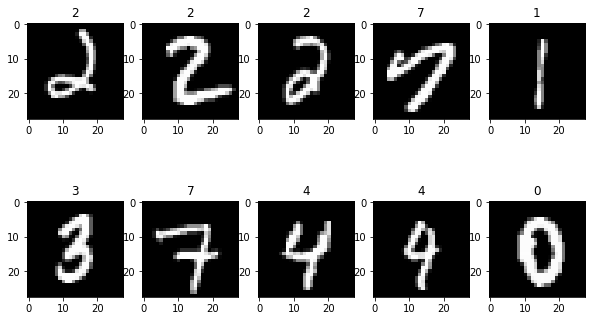

In [8]:
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_train.shape[0])
    plt.imshow(X_test[rand_ind,:,:],cmap='gray')
    plt.title(mnist_label_list[int(Y_test_scalar[rand_ind])])


Now, we carry out some data pre-processing. In particular, we normalise the data to the range $[0,1]$ and convert the labels to a one-hot encoding :

In [9]:
# input image dimensions (mnist data is grey-level)
img_rows, img_cols, nb_channels = X_train.shape[1], X_train.shape[2], 1

# In case depth is 1 (black and white pictures) -> reshape to proper format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, nb_channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, nb_channels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = to_categorical(Y_train_scalar)
Y_test = to_categorical(Y_test_scalar)

# number of classes
nb_classes = Y_train.shape[1]

print('X_train shape:', X_train.shape)
#print('y_train shape:', y_train.shape)
print('Y_train shape:', Y_train.shape)
print('There are {} train data'.format(X_train.shape[0]))
print('There are {} test data'.format(X_test.shape[0]))
print(img_rows, img_cols, nb_channels)


X_train shape: (5000, 28, 28, 1)
Y_train shape: (5000, 10)
There are 5000 train data
There are 5000 test data
28 28 1


## Defining the model for MNIST

We will now define the simple CNN described below, for use with MNIST. The input of the CNN is a set of (28,28,1) image tensors. We apply :

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - a ReLu activation function
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - A softmax activation function which outputs are the $P(y_c | X)$ (multi-class problem)

We define the parameters of the model :

In [12]:
learning_rate = 0.01
n_epochs = 10
batch_size = 64

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = nb_channels  # number of input channels
n_h_1 = nb_filters
n_h_2 = nb_filters

In [14]:


model = Sequential()
model.add(Conv2D(nb_filters, kernel_size,input_shape=(28,28,1),strides=(1, 1),padding="same",name="Conv1"))
model.add(Activation("relu"))
model.add(Conv2D(nb_filters, kernel_size,input_shape=(28,28,1),strides=(1, 1),padding="same",name="Conv2"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size,strides=(2, 2)))
model.add(Flatten())
model.add(Dense(10,  activation = 'softmax'))




In [15]:
# compile, train and evaluate model

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(X_train,Y_train,epochs=10,batch_size=batch_size)


score = model.evaluate(X_test, Y_test, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 28, 28, 32)        320       
                                                                 
 activation_2 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 28, 28, 32)        9248      
                                                                 
 activation_3 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                      

This is pretty good ! However, this is normal. Unfortunately, everything works with mnist (unless you have gotten the model really wrong). So often, mnist is just used as a sanity check. Let's now look at a more complex dataset : CIFAR10

## 2/ CNN on CIFAR10

Cifar10 has ten categories, which are much more complex than the digits in mnist. In this case, we are going to add more layers to increase the capacity of the network. We create the following network :

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - a ReLu activation function
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - A softmax activation function which outputs are the $P(y_c | X)$ (multi-class problem)


As previsously, we investigate the data, display some samples, and we carry out some pre-processing.

### Import data

In [16]:
from tensorflow.keras.datasets import cifar10
(X_train, Y_train_scalar), (X_test, Y_test_scalar) = cifar10.load_data()

print("Train data shape : ", X_train.shape)
print("Test data shape : ", X_test.shape)
print("Number of data categories : ", np.unique(Y_train_scalar))

170508288/170498071 [==============================] - 3s 0us/step
Train data shape :  (50000, 32, 32, 3)
Test data shape :  (10000, 32, 32, 3)
Number of data categories :  [0 1 2 3 4 5 6 7 8 9]


The CIFAR-10 dataset has 10 classes. These are the following :

In [17]:
cifar_10_list = [ 'airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

### Display some of the images

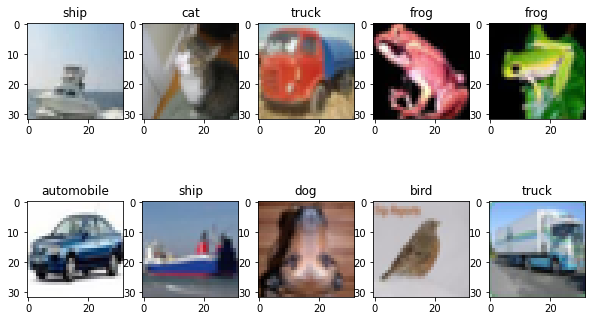

In [18]:
plt.figure(figsize=(10, 6))
for idx,i in enumerate(range(100,110)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(X_train[i, :, :, :])
    plt.title(cifar_10_list[int(Y_train_scalar[i])])

As you can see, the images are in quite small resolution. This makes them more easy to handle computationally, however it also means that they are quite difficult to analyse, even for a human being. Therefore, __we might not get that great accuracy scores__. The goal is not to get great scores (this would take longer training and potentially a larger network).

## Format conversion

In [19]:
# input image dimensions
img_rows, img_cols, nb_channels = 32, 32, 3
nb_classes = 10

# In case depth is 1 (black and white pictures) -> reshape to proper format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, nb_channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, nb_channels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# convert to one-hot encoding
Y_train = to_categorical(Y_train_scalar)
Y_test = to_categorical(Y_test_scalar)

print('X_train shape:', X_train.shape)
print('Y_train_scalar shape:', Y_train_scalar.shape)
print('Y_train shape (one hot encoding):', Y_train.shape)
print('There is {} train data'.format(X_train.shape[0]))
print('There is {} test data'.format(X_test.shape[0]))
print(img_rows, img_cols, nb_channels)

X_train shape: (50000, 32, 32, 3)
Y_train_scalar shape: (50000, 1)
Y_train shape (one hot encoding): (50000, 10)
There is 50000 train data
There is 10000 test data
32 32 3


For computational reasons, we are going to reduce the amount of training data :

In [20]:
n_train_samples = 10000
X_train = X_train[0:n_train_samples,:,:,:]
Y_train = Y_train[0:n_train_samples,:]
print(X_train.shape)
print(Y_train.shape)

(10000, 32, 32, 3)
(10000, 10)




We are now going to create the model described just above, and train it on the previously loaded CIFAR dataset.

## We define the parameters of the model, and of the training

In [21]:

learning_rate = 0.01
n_epochs = 20
batch_size = 64
# number of convolutional filters to use
nb_filters = 32 

# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)


# --- Size of the successice layers
n_h_0 = nb_channels
n_h_1 = nb_filters
n_h_2 = nb_filters
n_h_3 = nb_filters

input_shape = (img_rows, img_cols, nb_channels)


Now, define the model :

In [22]:


model = Sequential()
model.add(Conv2D(nb_filters, kernel_size,input_shape=(32,32,3),strides=(1, 1),padding="same",name="Conv1"))
model.add(Activation("relu"))
model.add(Conv2D(nb_filters, kernel_size,input_shape=(32,32,3),strides=(1, 1),padding="same",name="Conv2"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size,strides=(2, 2)))
model.add(Conv2D(nb_filters, kernel_size,input_shape=(32,32,3),strides=(1, 1),padding="same",name="Conv3"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size,strides=(2, 2)))
model.add(Flatten())
model.add(Dense(10,  activation = 'softmax'))



Again, compile, display and train the model

In [23]:

model.compile("adam",loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(X_train,Y_train,epochs=n_epochs,batch_size=batch_size)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 activation_4 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 activation_5 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 32)        9248      
                                                      

Evaluate the performances of the model on the test data




In [24]:
score = model.evaluate(X_test, Y_test, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5587130784988403
Test accuracy: 0.6008999943733215


0.6 is not great, but it's not that bad considering there are 10 categories. A random choice would give an accuracy of 0.1. However, there are several points to consider here :

- The data is more complex than that of mnist for example : there are a lot more variations of "dog"s than "1"s. Therefore, the network has to be larger
- The resolution is  32$\times$32, therefore even for humans it is difficult to recognise some of the images
- Unfortunately, when we start dealing with larger networks, the possibilities for falling into local minima become more and more present. There is no way around this more the moment, due to lack of theoretical understanding. If you do have an idea of how to do this, please email me and we will most likely become very rich.



### Inspecting the network's results

Let's take a look at what the network has learned. What do you think ?

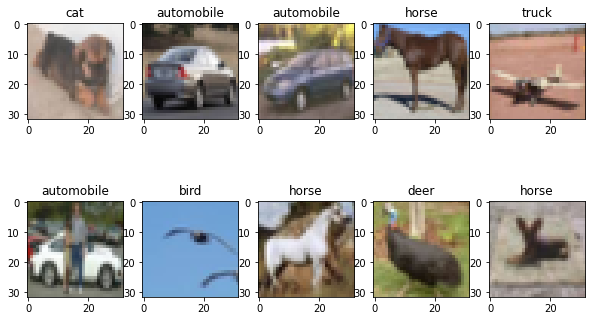

In [25]:
plt.figure(figsize=(10, 6))
for idx,i in enumerate(range(100,110)):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    predicted_class = np.argmax(np.squeeze(model.predict(np.expand_dims(X_test[rand_ind,:,:,:],axis=0)))) # FILL IN CODE
    plt.imshow(X_test[rand_ind,:,:,:])
    plt.title(cifar_10_list[int(predicted_class)])